Домашнее задание по теме «Полиномиальная регрессия»

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

Загружаем данные

In [2]:
train_df=pd.read_csv('train.csv', index_col='id')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.00"
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.00"
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.00"


In [14]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

Можно заметить, что в таблице есть пропуски. Так как данных много, можно просто убрать пустые строчки

In [4]:
train_df = train_df.dropna()
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   384004 non-null  float64
 1   Gender                384004 non-null  object 
 2   Annual Income         384004 non-null  float64
 3   Marital Status        384004 non-null  object 
 4   Number of Dependents  384004 non-null  float64
 5   Education Level       384004 non-null  object 
 6   Occupation            384004 non-null  object 
 7   Health Score          384004 non-null  float64
 8   Location              384004 non-null  object 
 9   Policy Type           384004 non-null  object 
 10  Previous Claims       384004 non-null  float64
 11  Vehicle Age           384004 non-null  float64
 12  Credit Score          384004 non-null  float64
 13  Insurance Duration    384004 non-null  float64
 14  Policy Start Date     384004 non-null  object 
 15  Cust

В Policy Start Date записано год, месяц, день и даже время. Так как это категориальная переменная её придется закодировать. Чтобы уменьшить кол-во данных для кодировки заменим этот столбец на Policy Start Year. В нем будет храниться только год из даты.

In [5]:
train_df['Policy Start Year'] = pd.DatetimeIndex(train_df['Policy Start Date']).year
train_df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
id,,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,...,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.00",2023
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,...,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.00",2021
7,48.00,Female,"127,237.00",Divorced,2.00,High School,Employed,5.77,Suburban,Comprehensive,...,11.00,398.00,5.00,2022-08-08 15:21:39.181605,Average,No,Rarely,Condo,111.00,2022
9,44.00,Male,"52,447.00",Married,2.00,Master's,Employed,20.47,Urban,Comprehensive,...,9.00,635.00,3.00,2020-08-02 15:21:39.144722,Poor,No,Daily,Condo,64.00,2020
15,18.00,Male,"6,076.00",Married,2.00,High School,Employed,7.44,Urban,Premium,...,12.00,584.00,5.00,2020-10-17 15:21:39.209847,Good,Yes,Monthly,Apartment,849.00,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,51.00,Male,"6,011.00",Single,4.00,Master's,Unemployed,41.66,Suburban,Comprehensive,...,16.00,547.00,9.00,2022-11-03 15:21:39.222387,Average,Yes,Monthly,House,563.00,2022
1199985,45.00,Male,"39,724.00",Married,0.00,Bachelor's,Employed,29.46,Suburban,Basic,...,13.00,519.00,4.00,2020-11-29 15:21:39.085129,Average,No,Monthly,House,563.00,2020
1199986,19.00,Male,"1,098.00",Divorced,4.00,High School,Employed,13.10,Suburban,Comprehensive,...,17.00,551.00,3.00,2019-08-27 15:21:39.218388,Average,No,Weekly,Condo,"2,760.00",2019


In [6]:
train_df = train_df.drop('Policy Start Date', axis=1)
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
id,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,Poor,No,Weekly,House,"2,869.00",2023
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,Poor,Yes,Weekly,House,"2,022.00",2021
7,48.00,Female,"127,237.00",Divorced,2.00,High School,Employed,5.77,Suburban,Comprehensive,1.00,11.00,398.00,5.00,Average,No,Rarely,Condo,111.00,2022
9,44.00,Male,"52,447.00",Married,2.00,Master's,Employed,20.47,Urban,Comprehensive,1.00,9.00,635.00,3.00,Poor,No,Daily,Condo,64.00,2020
15,18.00,Male,"6,076.00",Married,2.00,High School,Employed,7.44,Urban,Premium,1.00,12.00,584.00,5.00,Good,Yes,Monthly,Apartment,849.00,2020


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [7]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col.append('Policy Start Year')
category_col

['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type',
 'Policy Start Year']

In [8]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).drop('Policy Start Year', axis=1).columns.tolist()
train_df_num = train_df[number_col]

Для кодирования категориальных переменных будем использовать TargetOrdinalEncoding

In [9]:
def TargetOrdinalEncoding(df, col):
    ordinal_index = df.groupby([col])['Premium Amount'].mean().sort_values().index
    ordinal_label={k:i for i,k in enumerate(ordinal_index, 0)}
    df[f'{col}_ordinal_label']=df[col].map(ordinal_label)
    return df

In [ ]:
for col in category_col:
    train_df = TargetOrdinalEncoding(train_df,col)
train_df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
id,,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,...,1,2,1,1,0,2,0,2,1,2
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,...,2,2,1,0,0,2,1,2,1,1
7,48.00,Female,"127,237.00",Divorced,2.00,High School,Employed,5.77,Suburban,Comprehensive,...,0,3,2,2,1,0,0,1,2,0
9,44.00,Male,"52,447.00",Married,2.00,Master's,Employed,20.47,Urban,Comprehensive,...,1,0,2,1,1,2,0,3,2,3
15,18.00,Male,"6,076.00",Married,2.00,High School,Employed,7.44,Urban,Premium,...,1,3,2,1,0,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,51.00,Male,"6,011.00",Single,4.00,Master's,Unemployed,41.66,Suburban,Comprehensive,...,2,0,0,2,1,0,1,0,1,0
1199985,45.00,Male,"39,724.00",Married,0.00,Bachelor's,Employed,29.46,Suburban,Basic,...,1,2,2,2,2,0,0,0,1,3
1199986,19.00,Male,"1,098.00",Divorced,4.00,High School,Employed,13.10,Suburban,Comprehensive,...,0,3,2,2,1,0,0,2,2,5


In [ ]:
train_df = train_df.drop(category_col, axis=1)
train_df

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_ordinal_label,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
id,,,,,,,,,,,,,,,,,,,,
0,19.00,"10,049.00",1.00,22.60,2.00,17.00,372.00,5.00,"2,869.00",0,1,2,1,1,0,2,0,2,1,2
4,21.00,"39,651.00",1.00,20.38,0.00,8.00,598.00,4.00,"2,022.00",1,2,2,1,0,0,2,1,2,1,1
7,48.00,"127,237.00",2.00,5.77,1.00,11.00,398.00,5.00,111.00,0,0,3,2,2,1,0,0,1,2,0
9,44.00,"52,447.00",2.00,20.47,1.00,9.00,635.00,3.00,64.00,1,1,0,2,1,1,2,0,3,2,3
15,18.00,"6,076.00",2.00,7.44,1.00,12.00,584.00,5.00,849.00,1,1,3,2,1,0,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,51.00,"6,011.00",4.00,41.66,1.00,16.00,547.00,9.00,563.00,1,2,0,0,2,1,0,1,0,1,0
1199985,45.00,"39,724.00",0.00,29.46,1.00,13.00,519.00,4.00,563.00,1,1,2,2,2,2,0,0,0,1,3
1199986,19.00,"1,098.00",4.00,13.10,1.00,17.00,551.00,3.00,"2,760.00",1,0,3,2,2,1,0,0,2,2,5


In [213]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               384004 non-null  float64
 1   Annual Income                     384004 non-null  float64
 2   Number of Dependents              384004 non-null  float64
 3   Health Score                      384004 non-null  float64
 4   Previous Claims                   384004 non-null  float64
 5   Vehicle Age                       384004 non-null  float64
 6   Credit Score                      384004 non-null  float64
 7   Insurance Duration                384004 non-null  float64
 8   Premium Amount                    384004 non-null  float64
 9   Gender_ordinal_label              384004 non-null  int64  
 10  Marital Status_ordinal_label      384004 non-null  int64  
 11  Education Level_ordinal_label     384004 non-null  int64

Уменьшим вес таблицы с помощью изменения типа данных.

In [12]:
int_cols = train_df.select_dtypes('int').columns

float_cols = train_df.select_dtypes('float').columns
for col in int_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='integer')
for col in float_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='float')

In [13]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               384004 non-null  float32
 1   Annual Income                     384004 non-null  float32
 2   Number of Dependents              384004 non-null  float32
 3   Health Score                      384004 non-null  float32
 4   Previous Claims                   384004 non-null  float32
 5   Vehicle Age                       384004 non-null  float32
 6   Credit Score                      384004 non-null  float32
 7   Insurance Duration                384004 non-null  float32
 8   Premium Amount                    384004 non-null  float32
 9   Gender_ordinal_label              384004 non-null  int8   
 10  Marital Status_ordinal_label      384004 non-null  int8   
 11  Education Level_ordinal_label     384004 non-null  int8 

# EDA

Для числовых столбцов:

In [77]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,0.00
Annual Income,0.00
Number of Dependents,0.00
Health Score,0.00
Previous Claims,0.00
Vehicle Age,0.00
Credit Score,0.00
Insurance Duration,0.00
Premium Amount,0.00


In [78]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
Age,64.00,18.00
Annual Income,"149,997.00",2.00
Number of Dependents,4.00,0.00
Health Score,58.45,2.02
Previous Claims,8.00,0.00
Vehicle Age,19.00,0.00
Credit Score,849.00,300.00
Insurance Duration,9.00,1.00
Premium Amount,"4,997.00",20.00


In [79]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
Age,41.14
Annual Income,"33,072.90"
Number of Dependents,2.01
Health Score,25.58
Previous Claims,1.00
Vehicle Age,9.56
Credit Score,594.01
Insurance Duration,5.02
Premium Amount,"1,113.19"


In [80]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
Age,41.00
Annual Income,"24,182.00"
Number of Dependents,2.00
Health Score,24.58
Previous Claims,1.00
Vehicle Age,10.00
Credit Score,596.00
Insurance Duration,5.00
Premium Amount,882.00


In [81]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
Age,183.11
Annual Income,"1,047,837,723.21"
Number of Dependents,2.00
Health Score,148.70
Previous Claims,0.96
Vehicle Age,33.34
Credit Score,"22,382.46"
Insurance Duration,6.74
Premium Amount,"754,619.46"


In [82]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
Age,22.00,60.00
Annual Income,"2,673.00","81,459.00"
Number of Dependents,0.00,4.00
Health Score,9.91,43.18
Previous Claims,0.00,2.00
Vehicle Age,2.00,18.00
Credit Score,385.00,793.00
Insurance Duration,1.00,9.00
Premium Amount,155.00,"2,379.00"


In [83]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
Age,30.00,53.00
Annual Income,"8,069.00","44,803.00"
Number of Dependents,1.00,3.00
Health Score,15.88,34.49
Previous Claims,0.00,2.00
Vehicle Age,5.00,15.00
Credit Score,470.00,722.00
Insurance Duration,3.00,7.00
Premium Amount,519.00,"1,520.00"


Для категориальных столбцов:

In [84]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
Gender,0.00
Marital Status,0.00
Education Level,0.00
Occupation,0.00
Location,0.00
Policy Type,0.00
Customer Feedback,0.00
Smoking Status,0.00
Exercise Frequency,0.00
Property Type,0.00


In [85]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
Gender,2
Marital Status,3
Education Level,4
Occupation,3
Location,3
Policy Type,3
Customer Feedback,3
Smoking Status,2
Exercise Frequency,4
Property Type,3


In [86]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
Gender,Male
Marital Status,Single
Education Level,PhD
Occupation,Self-Employed
Location,Suburban
Policy Type,Premium
Customer Feedback,Average
Smoking Status,Yes
Exercise Frequency,Weekly
Property Type,Apartment


# Обработка данных

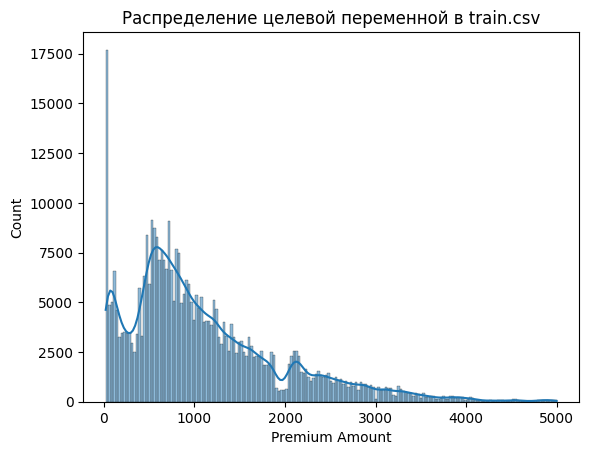

In [ ]:
sns.histplot(train_df['Premium Amount'], kde=True)
plt.title("Распределение целевой переменной в train.csv")
plt.show()

Можно заметить несколько скачков в графике. Посмотрим на распределение данных во всей таблице

In [87]:
# посчитаем квантили распределения
train_df['Premium Amount'].describe(percentiles=[0.1, 0.25, 0.75, 0.95 ])

count   384,004.00
mean      1,090.53
std         803.54
min          20.00
10%         155.00
25%         519.00
50%         882.00
75%       1,520.00
95%       2,886.00
max       3,021.50
Name: Premium Amount, dtype: float64

In [88]:
train_df.describe(include='all')

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_ordinal_label,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
count,"384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00","384,004.00"
mean,41.14,"31,741.38",2.01,25.58,1.00,9.56,594.01,5.02,"1,090.53",0.50,1.00,1.48,1.01,1.00,1.00,1.00,0.50,1.50,1.00,2.04
std,13.53,"28,744.88",1.42,12.19,0.98,5.77,149.61,2.60,803.54,0.50,0.82,1.11,0.81,0.82,0.82,0.82,0.50,1.11,0.82,1.53
min,18.00,2.00,0.00,2.02,0.00,0.00,300.00,1.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,30.00,"8,069.00",1.00,15.88,0.00,5.00,470.00,3.00,519.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
50%,41.00,"24,182.00",2.00,24.58,1.00,10.00,596.00,5.00,882.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00
75%,53.00,"44,803.00",3.00,34.49,2.00,15.00,722.00,7.00,"1,520.00",1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,3.00
max,64.00,"99,904.00",4.00,58.45,5.00,19.00,849.00,9.00,"3,021.50",1.00,2.00,3.00,2.00,2.00,2.00,2.00,1.00,3.00,2.00,5.00


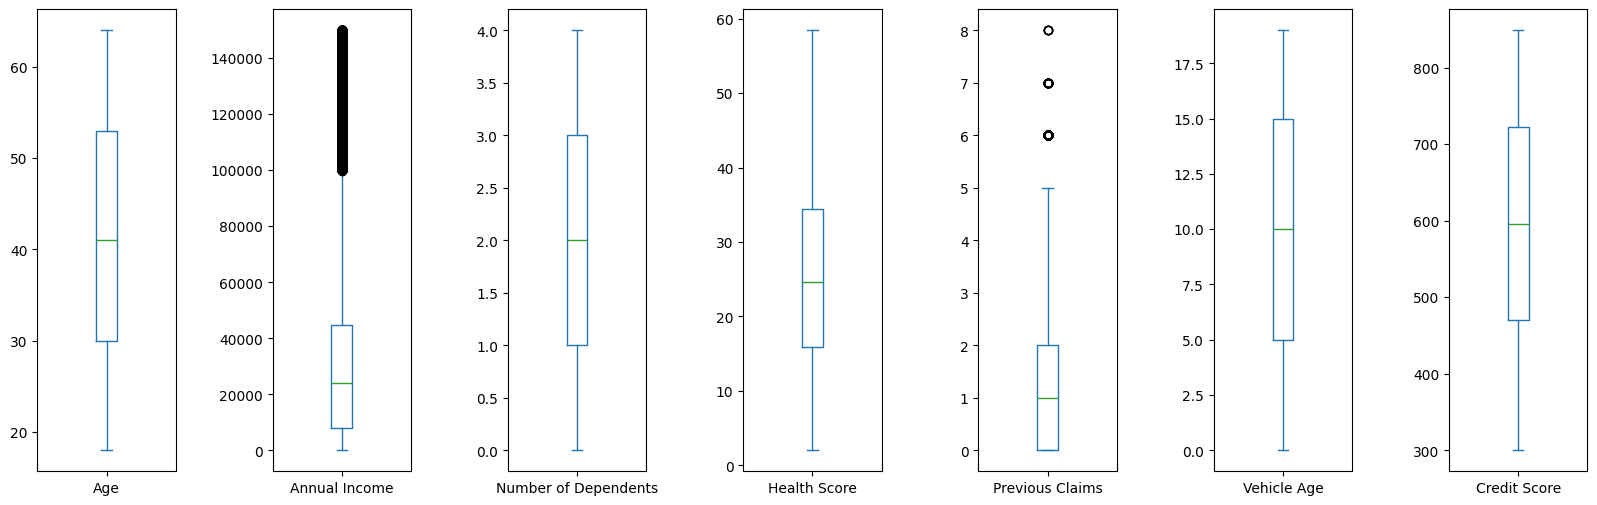

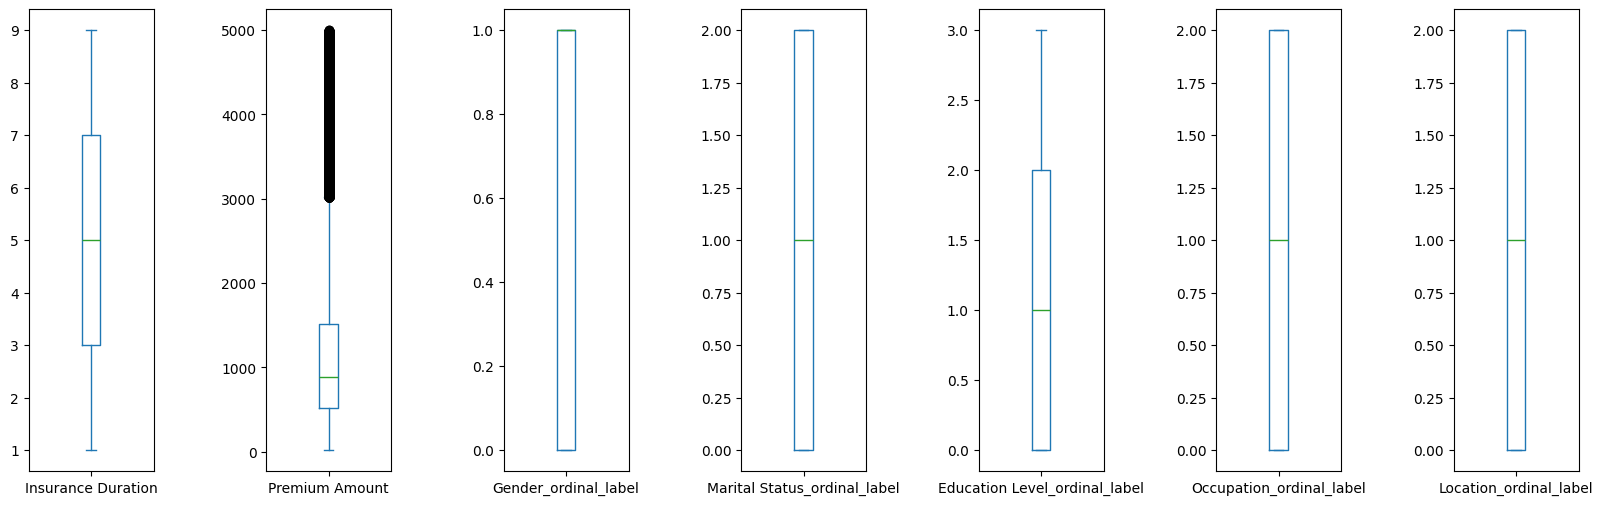

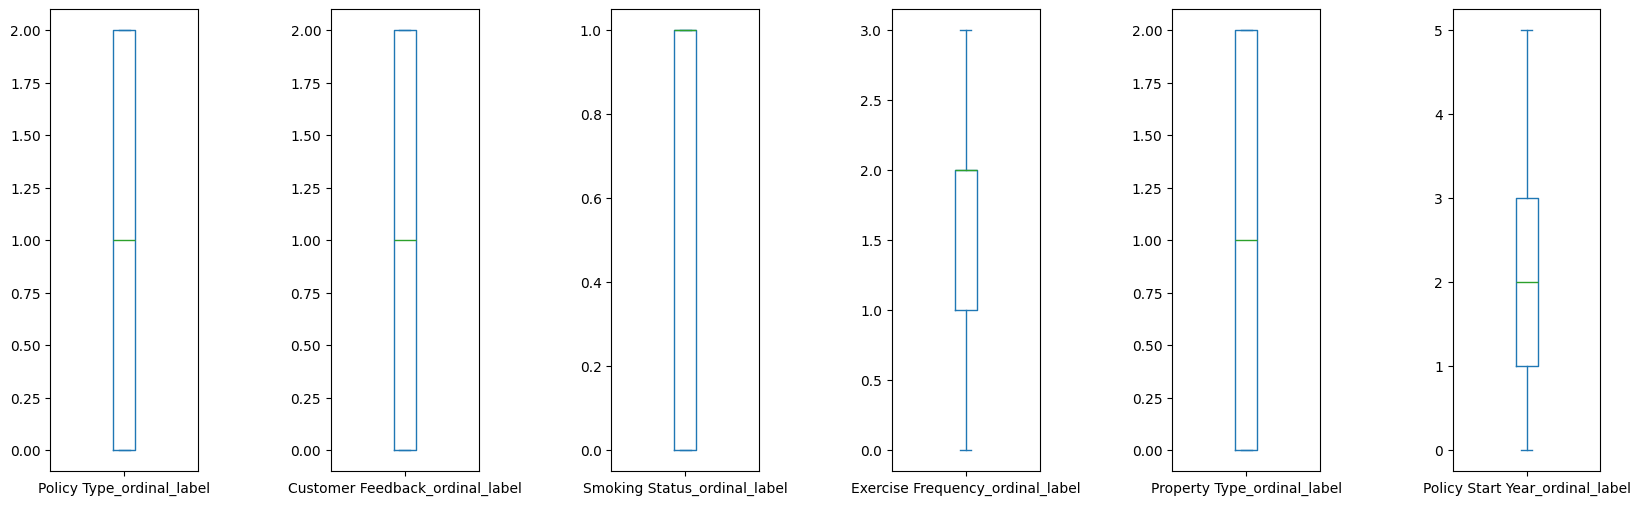

In [216]:
train_df.iloc[:,:7].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df.iloc[:,7:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбцах 'Annual Income', 'Previous Claims', 'Premium Amount' можно заметить выбросы. Избавимся от них

In [14]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df

In [ ]:
for col in ['Annual Income', 'Previous Claims', 'Premium Amount']:
    train_df = RemoveOutliers(train_df, col)

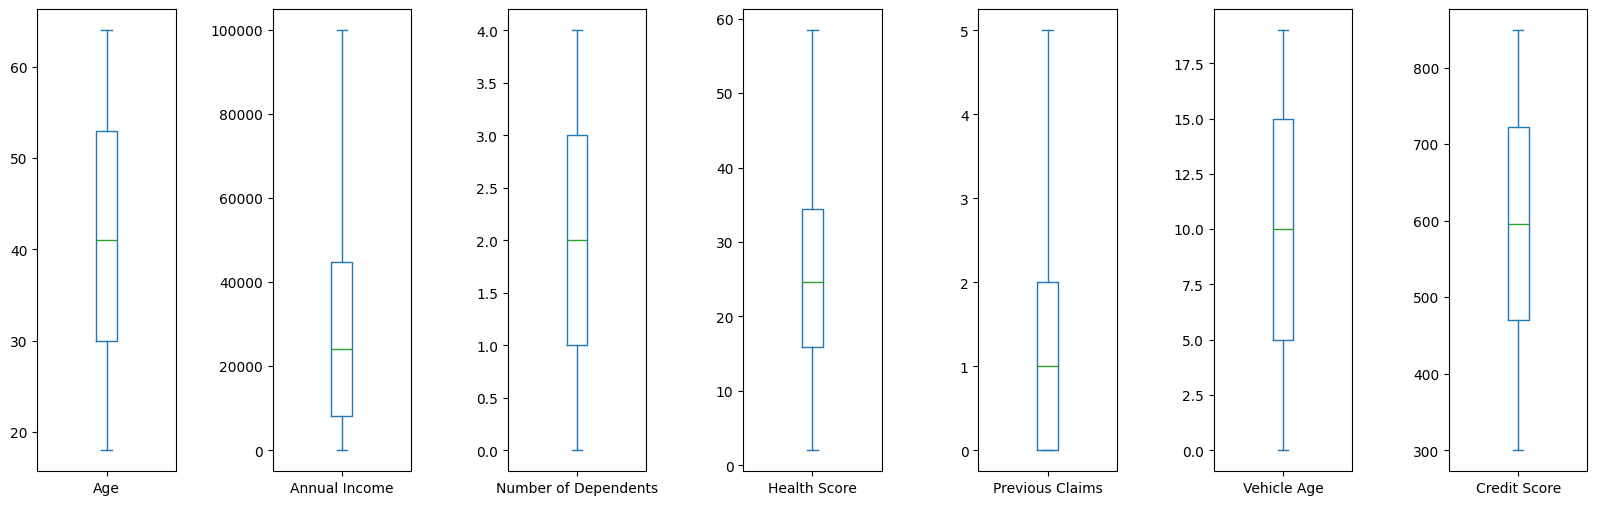

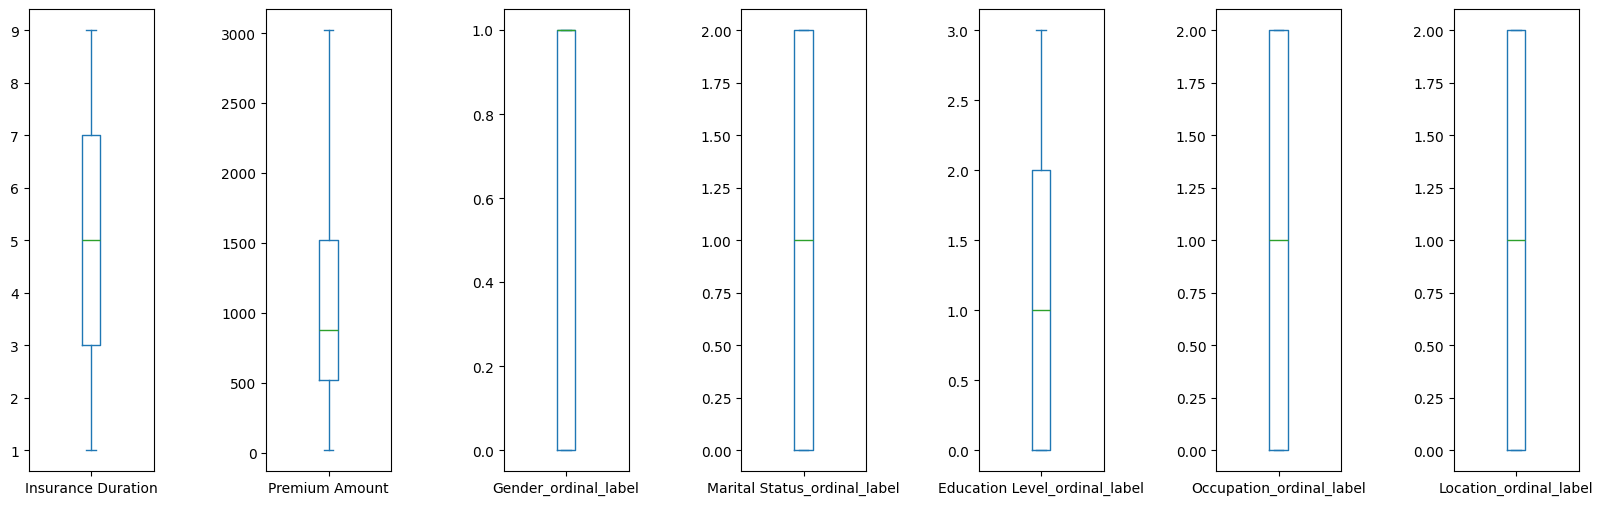

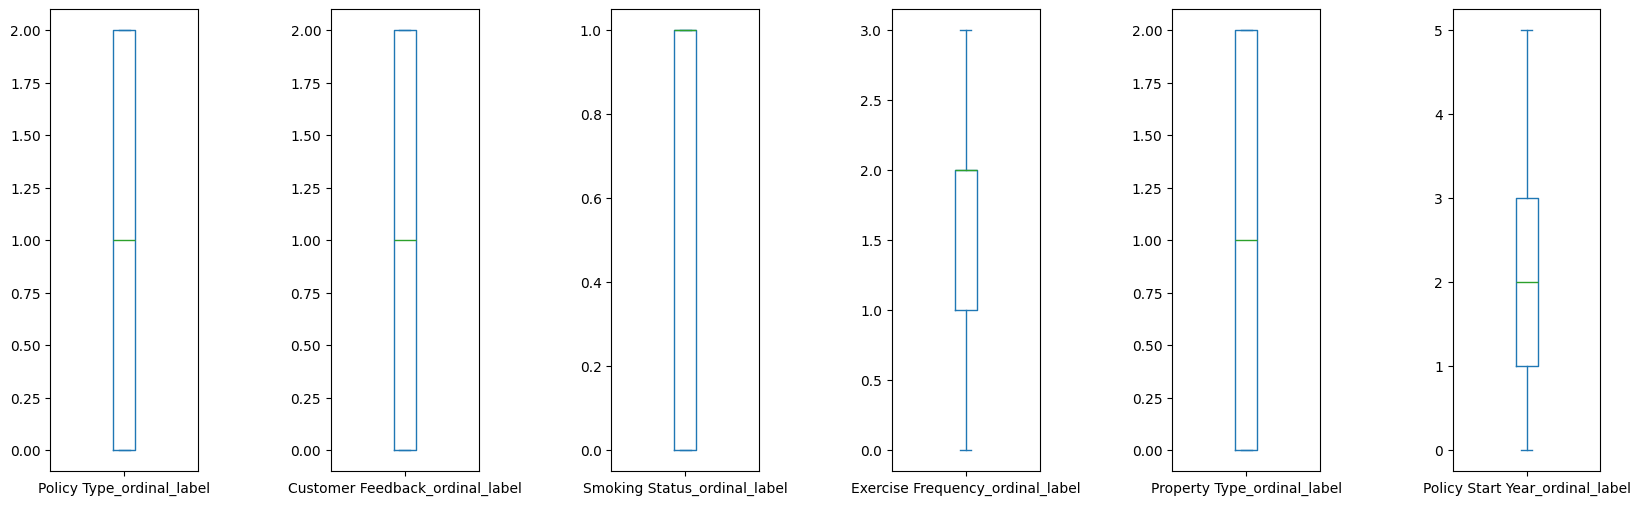

In [ ]:
train_df.iloc[:,:7].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df.iloc[:,7:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

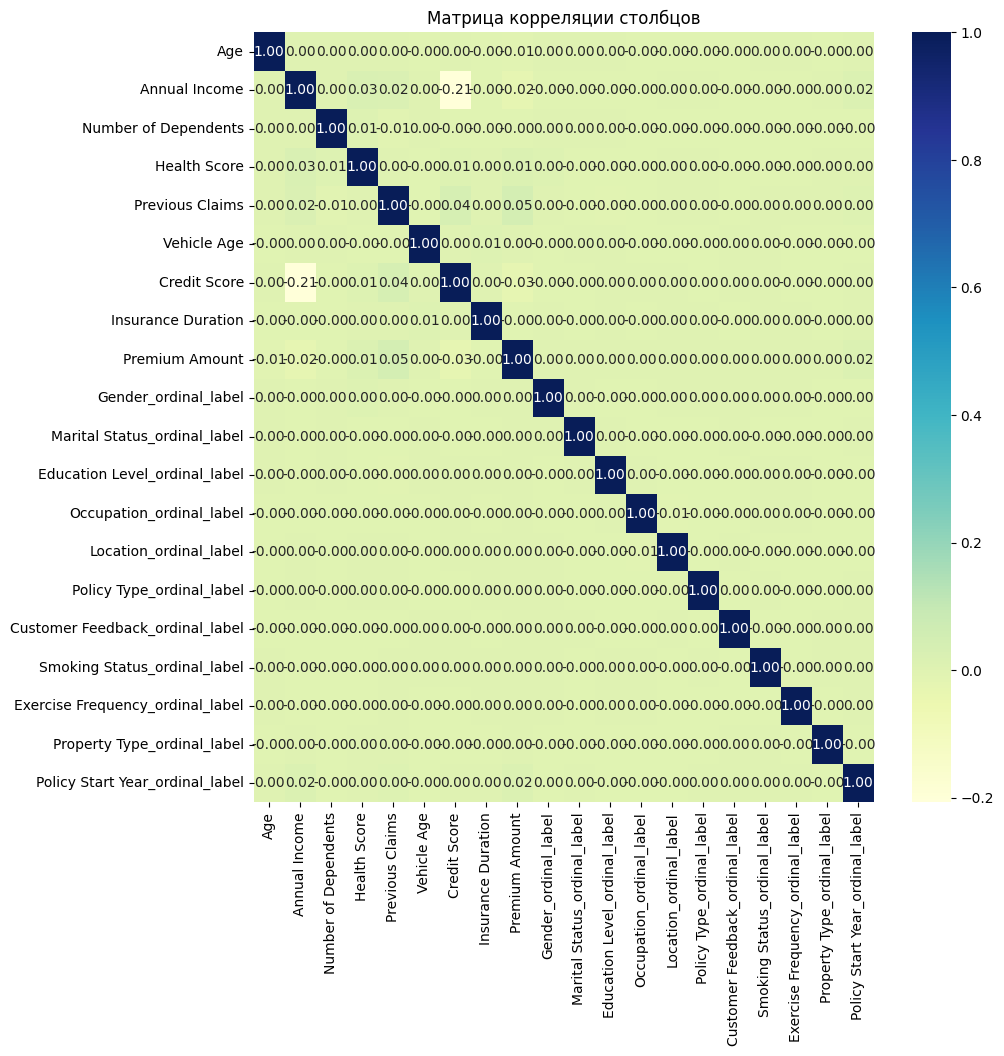

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции столбцов")
plt.show()

Между столбцами нет сильной корреляции. Нет необходимости какой-либо из них удалять.

# Обучение моделей

In [95]:
X = train_df.drop('Premium Amount', axis=1)
Y = train_df['Premium Amount']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state = 42)

In [97]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

def trainModels(X_train, X_test, y_train, y_test, stop = 3):
    """
    Тренирует регрессии от линейной до полиноминальной степени stop-1
    """
    Regression_error = {}
    for deg in range(1,stop):
        model = LinearRegression()
        if deg != 1:
            poly_features = PolynomialFeatures(degree=deg, include_bias = False)
            X_train = poly_features.fit_transform(X_train)
            X_test = poly_features.transform(X_test)
            poly_features.fit(X_train, y_train)
        model.fit(X_train, y_train)
        Y_pred_test = model.predict(X_test)
        Regression_error[f'Regression {deg}'] = {"R^2": r2_score(y_test, Y_pred_test),"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}
    return Regression_error

In [99]:
errors_df = pd.DataFrame(trainModels(X_train, X_test, y_train, y_test))
errors_df

,Regression 1,Regression 2
R^2,0.00,0.01
RMSE,802.49,799.47
MSE,"643,986.81","639,147.38"
MAE,643.51,639.65


Полиноминальная регрессия показала себя лучше.

Мой ноутбук не дает подняться выше 2 полиноминальной регрессии. Поэтому обучим ещё модели на части данных.

In [ ]:
train_df_half = train_df.sample(n=550).sort_index()
train_df_half.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 161 to 1191653
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               550 non-null    float32
 1   Annual Income                     550 non-null    float32
 2   Number of Dependents              550 non-null    float32
 3   Health Score                      550 non-null    float32
 4   Previous Claims                   550 non-null    float32
 5   Vehicle Age                       550 non-null    float32
 6   Credit Score                      550 non-null    float32
 7   Insurance Duration                550 non-null    float32
 8   Premium Amount                    550 non-null    float32
 9   Gender_ordinal_label              550 non-null    int8   
 10  Marital Status_ordinal_label      550 non-null    int8   
 11  Education Level_ordinal_label     550 non-null    int8   
 12  Occupat

In [89]:
from sklearn.preprocessing import StandardScaler

X = train_df_half.drop('Premium Amount', axis=1)
Y = train_df_half['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state = 42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [ ]:
errors_df_half = pd.DataFrame(trainModels(X_train, X_test, y_train, y_test,4))
errors_df_half

,Regression 1,Regression 2,Regression 3
R^2,-0.17,-5.55,0.00
RMSE,872.69,"2,063.95",806.19
MSE,"761,583.69","4,259,887.00","649,949.31"
MAE,702.80,"1,616.81",656.81


С меньшим набором данных можно увидеть, что полиноминальная регрессия 3 степени, дала лучшие результаты. Можно заметить, что с меньшим набором данных качество модели ухудшилось, но сравнивая с первыми результатами, можно прежположить, что полиноминальная регрессия 3 степени проявила бы себя лучше 2 степени.

Сделаем кросс-валидацию

In [ ]:
poly_features = PolynomialFeatures(degree=3, include_bias = False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.transform(X_test)
poly_features.fit(X_train, y_train)
cross_val_model = LinearRegression()

In [ ]:
cross_val_output = {}
cross_val_mae = - 1 * cross_val_score(cross_val_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cross_val_output['MAE'] = cross_val_mae.mean()
cross_val_mse = - 1 * cross_val_score(cross_val_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cross_val_output['MSE'] =cross_val_mse.mean()
cross_val_rmse = - 1 * cross_val_score(cross_val_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
cross_val_output['RMSE'] =cross_val_rmse.mean()
cross_val_r2 = - 1 * cross_val_score(cross_val_model, X_train, y_train, cv=5, scoring='r2')
cross_val_output['R^2'] =cross_val_r2.mean()

# Оценка качества

In [71]:
errors_final = errors_df_half
errors_final['Cross validation for 3 deg'] = cross_val_output

errors_final

,Regression 1,Regression 2,Regression 3,Cross validation for 3 deg
R^2,-0.17,-5.55,0.00,0.07
RMSE,872.69,"2,063.95",806.19,822.13
MSE,"761,583.69","4,259,887.00","649,949.31","685,132.02"
MAE,702.80,"1,616.81",656.81,673.52


Кросс-валидация показала, что качество полиноминальной модели осталось на примерно таком же уровне, как и было выявлено с помошью R^2, RMSE и т.д.